## Stochastic Sampling methods

**Goal**: Sample random values from a multidimensional pdf $\rho(x)$. In many appplications $\rho(x)$ is unnormalized, thus avoiding normalization step is beneficial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

## Analytical Sampling

Let $X \sim \mathcal{D}$ be distributed according to some 1D distribution $\mathcal{D}$, and $U \sim \mathcal{U}(0, 1)$ be a uniform random number. Then $X = F^{-1}(U)$, where $F(x) = \int_{-\infty}^{x}\rho_{\mathcal{D}}(x)dx$ is the CDF of the distribution of interest

**Downsides**
* Only works for 1D

**Example**: See page on CDF in basic-examples

## Gibbs sampling

An approximation of analytical sampling for multiple dimensions:
1. Find analytical conditional 1D distributions for each one value given the rest
2. During each iteration, update one value at a time, using most recent values of the rest
3. Create new sample point, once all parameters have been updated

**Downsides**:
* Need to be able to compute 1D distributions analytically
* This is an approximation, and may not be accurate if the values are strongly correlated

**Example**:

Let $\vec{X} \in \mathbb{R}^2$, s.t. $\vec{X} \sim \mathcal{N}(0, \Lambda)$. Then it can be shown, that

$$P[x_1 | x_2] = \frac{P[x_1,x_2]}{P[x_2]}
   \sim \mathcal{N} \biggl(-\frac{\Lambda_{12}}{\Lambda_{11}}x_2, \Lambda_{11} \biggr)$$
   
$$P[x_2 | x_1] = \frac{P[x_1,x_2]}{P[x_1]}
   \sim \mathcal{N} \biggl(-\frac{\Lambda_{12}}{\Lambda_{11}}x_1, \Lambda_{22} \biggr)$$


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


True mean: [0. 0.]
True cov:
 [[0.58834841 0.39223227]
 [0.39223227 0.58834841]]
Sample mean: [-0.00533054  0.0162062 ]
Sample cov:
 [[0.58323022 0.40462191]
 [0.40462191 0.60727414]]
Gibbs mean: [-5.78432321e-05 -1.86261786e-02]
Gibbs cov:
 [[0.60070265 0.39326113]
 [0.39326113 0.56817324]]


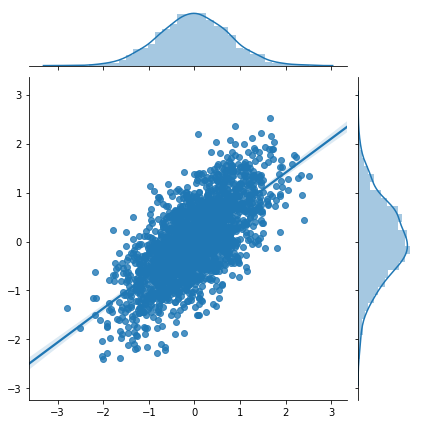

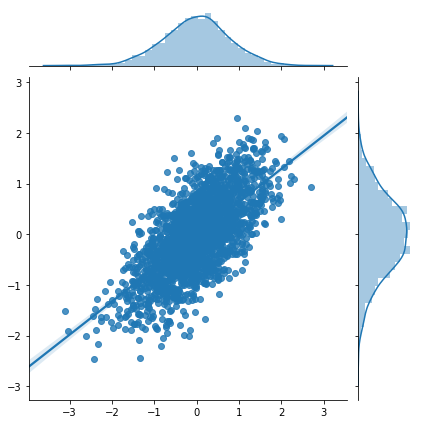

In [2]:
def rot(t):
    return np.array([[np.cos(t), np.sin(t)],[-np.sin(t), np.cos(t)]])

def cov2D(e, t):
    R = rot(t)
    cov = R.dot(np.diag(e)).dot(R.transpose())
    return cov / np.linalg.norm(cov)

N_SAMPLE = 2000

# Solution 1: Sample using implicit library
mean = np.zeros(2)
cov = cov2D([1,5], np.pi/4)
x_arr_2d = np.random.multivariate_normal(mean, cov, N_SAMPLE)
sns.jointplot(x_arr_2d[:, 0], x_arr_2d[:, 1], kind="reg")

print("True mean:", mean)
print("True cov:\n", cov)
print("Sample mean:", np.mean(x_arr_2d, axis=0))
print("Sample cov:\n", np.cov(x_arr_2d.transpose()))

# Solution 2: Use Gibbs sampling
covInv = np.linalg.inv(cov)
s1 = np.sqrt(1 / covInv[0][0])
s2 = np.sqrt(1 / covInv[1][1])
x_arr_2d_gibbs = np.zeros((N_SAMPLE, 2))
x_arr_2d_gibbs[0] = np.zeros(2)
for i in range(1, N_SAMPLE):
    m1 = -covInv[0][1] / covInv[0][0] * x_arr_2d_gibbs[i-1, 1]
    x_arr_2d_gibbs[i, 0] = np.random.normal(m1, s1)
    m2 = -covInv[0][1] / covInv[1][1] * x_arr_2d_gibbs[i, 0]
    x_arr_2d_gibbs[i, 1] = np.random.normal(m2, s2)
    
sns.jointplot(x_arr_2d_gibbs[:, 0], x_arr_2d_gibbs[:, 1], kind="reg")

print("Gibbs mean:", np.mean(x_arr_2d_gibbs, axis=0))
print("Gibbs cov:\n", np.cov(x_arr_2d_gibbs.transpose()))

## Gibbs sampling - Advanced

* **Block-sampling** - Sampling more than one variable at a time from joint distribution, if such is available
* **Collapsed Gibbs-Sampler** - Removing unnecessary variables by integrating them out from the original multivariate distribution

## Metropolis-Hastings

Produces markov chain, prioritizing points with higher probability, but sometimes randomly choosing lower probability points.
1. Sample $x_{n+1}$ from arbitrary distribution $Q(x_{n+1} | x_n)$
2. Compute acceptance ratio $\alpha = \frac{f(x_{n+1})}{f(x_{n})}$
3. $P[\mathrm{keep}] = \max(\alpha, 1)$. If reject, new point is a copy of previous point
4. Repeat 1-3 multiple times to generate the chain $MC = \{x_i\}$

**Downsides**:
* Burn-in - The beginning of the chain is dependent on the starting location and is typically non-representative of the rest of the chain. After the chain has converged, all values prior to convergergence need to be rejected.
* Autocorrelated - literature suggests keeping only every 14th point to make data points almost independent
* Slow compared to Gibbs sampling

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


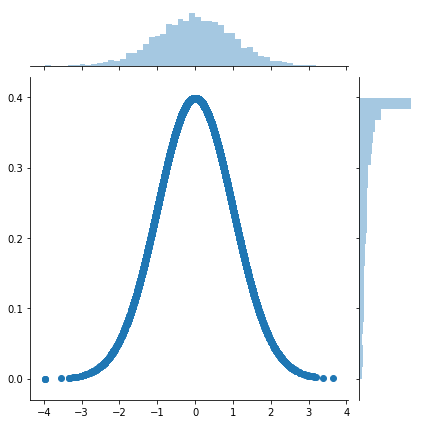

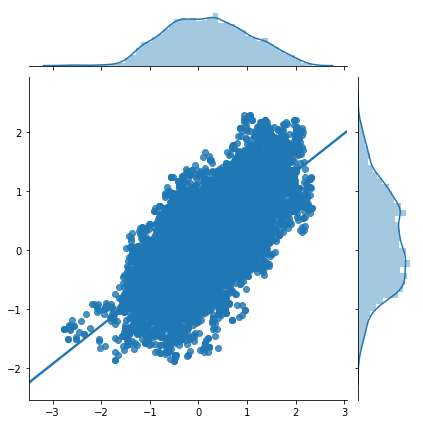

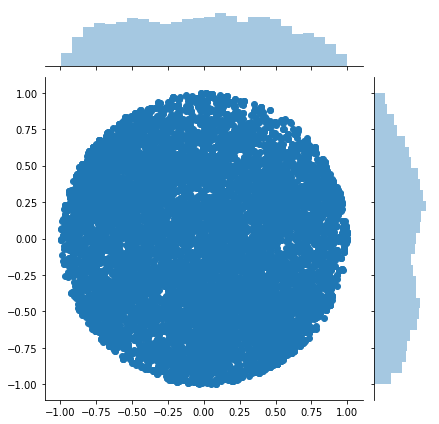

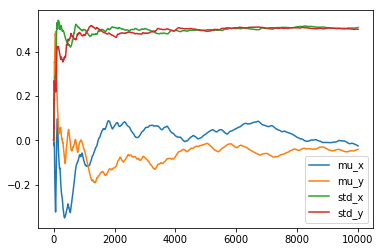

CPU times: user 4.88 s, sys: 1.21 s, total: 6.08 s
Wall time: 4.27 s


In [24]:
%%time
from mcmc_lib import sample_metropolis_hastings

# Sampling functions (centralized at previous point)
q1D_0 = lambda : np.random.normal(0, 1)
q2D_0 = lambda : np.random.normal([0, 0], [0.1, 0.1])

# Distributions
g1D_0 = multivariate_normal(0, 1)
g2D_0 = multivariate_normal(mean, cov)
circ1 = lambda x : np.greater_equal(1, x[0]**2 + x[1]**2)

x1, y1 = sample_metropolis_hastings(g1D_0.pdf, q1D_0, [0], 10000)
x2, y2 = sample_metropolis_hastings(g2D_0.pdf, q2D_0, [0, 0], 10000)
x3, y3 = sample_metropolis_hastings(circ1,     q2D_0, [0, 0], 10000)

sns.jointplot(x1[:, 0], y1)
sns.jointplot(x2[:, 0], x2[:, 1], kind="reg")
sns.jointplot(x3[:, 0], x3[:, 1])

# Compute convergence of moments for last example
run_mu = np.zeros((10000, 2))
run_std = np.zeros((10000, 2))

for i in range(3, 10000):
    run_mu[i] = np.mean(x3[:i], axis=0)
    run_std[i] = np.std(x3[:i], axis=0)
    
plt.figure()
plt.plot(run_mu[:, 0], label='mu_x')
plt.plot(run_mu[:, 1], label='mu_y')
plt.plot(run_std[:, 0], label='std_x')
plt.plot(run_std[:, 1], label='std_y')
plt.legend()
plt.show()

# Computation of Sample moments

The task is to compute the expectation value of an arbitrary function $f(x)$. The solution can be approximated by computing the mean of the function over a representative sample over the underlying distribution $\rho(x)$.

$$I = \langle f(x)\rangle_{\rho} = \int_{\Omega} f(x)\rho(x)dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i)$$

In [4]:
# Compute approximations to moment integrals
m1 = lambda x : np.mean(x, axis = 0)

def m2(x):
    sub = (x - m1(x))
    return sub.transpose().dot(sub) / sub.shape[0]

print("True Mean =", mean)
print("True Cov  =\n", cov)
print("Eval Mean =", m1(x2))
print("Eval Cov  =\n", m2(x2))

True Mean = [0. 0.]
True Cov  =
 [[0.58834841 0.39223227]
 [0.39223227 0.58834841]]
Eval Mean = [-0.02725408 -0.00836013]
Eval Cov  =
 [[0.66726043 0.40000804]
 [0.40000804 0.59908903]]
